# Практическая работа №4
## Тема: Деревья решений
Выполнила Фонград Анастасия КИ21-16/1б

In [299]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image, display
import pydotplus
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [300]:
class_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_2.csv")
class_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_2.csv")
regression_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_3.csv")
regression_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_3.csv")

## Предварительная обработка данных
Произведём пред обработку данных для задачи классификации

In [301]:
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
class_all = class_num + class_cat
class_result = "Response"
class_train.drop("id", axis=1, inplace=True)
class_test.drop("id", axis=1, inplace=True)
# Кодирование категориальных признаков
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column])
    class_test[column] = le.fit_transform(class_test[column])
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")
# Нормализация числовых признаков
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.fit_transform(class_test[class_num])
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


Отбросим часть тренировочной выборки

In [302]:
number_of_elements = 20000  # Количество элементов
class_train = class_train.sample(n=number_of_elements, replace=False)
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 206165 to 184763
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                20000 non-null  category
 1   Age                   20000 non-null  float64 
 2   Driving_License       20000 non-null  float64 
 3   Region_Code           20000 non-null  float64 
 4   Previously_Insured    20000 non-null  float64 
 5   Vehicle_Age           20000 non-null  category
 6   Vehicle_Damage        20000 non-null  category
 7   Annual_Premium        20000 non-null  float64 
 8   Policy_Sales_Channel  20000 non-null  float64 
 9   Vintage               20000 non-null  float64 
 10  Response              20000 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


Произведём пред обработку данных для задачи регрессии

In [303]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
# Удаляем некоторые категориальные признаки для избежания ловушки фиктивных переменных
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

Произведём сэмплирование данных для задачи классификации

In [304]:
def build_response_graph(column):
    """
    Строит распределение классов в выборке
    :param column: массив рассматриваемых значений
    """
    plt.pie(column.value_counts(), labels=(0, 1))
    plt.title("Распределение значения response в выборке")
    plt.legend((0, 1))
    plt.show()

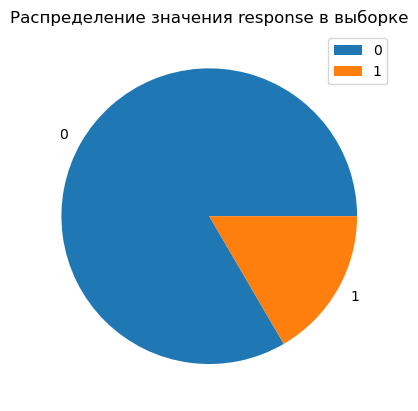

In [305]:
build_response_graph(class_train[class_result])

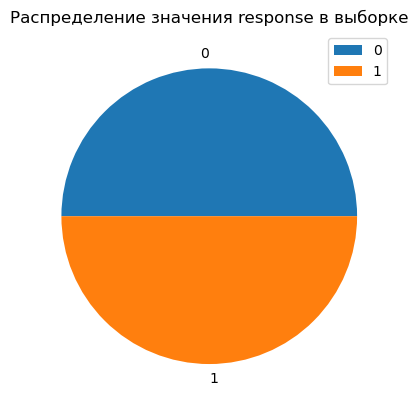

In [306]:
x = class_train[class_all]
y = class_train[class_result]
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
build_response_graph(y)

Разобьём выборки на train и test

In [307]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение деревьев решений

In [308]:
def compare_parameters(parameters, test_scores, train_scores, is_regression=False):
    """
    Строит графики зависимости параметров моделей от её score
    :param parameters: словарь параметров
    :param test_scores: оценки модели, полученные на тестовой выборке
    :param train_scores: оценки модели, полученные на тренировочной выборке
    :param is_regression: рассматриваем ли задачу регрессии
    """
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
    fig.subplots_adjust(hspace=0.4)
    id = 0
    ax_arr = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]
    for key in test_scores.keys():
        if key != "criterion":
            plot_accuracy_graph(parameters[key], key, ax_arr[id], train_scores[key], test_scores[key], regression=is_regression)
        else:
            plot_criteria(parameters[key], ax_arr[id], train_scores[key], test_scores[key], regression=is_regression)
        id += 1

In [309]:
def create_best_model(params, is_regression=False):
    """
    Создаёт модель с наилучшими параметрами
    :param params: параметры модели
    :param is_regression: рассматриваем ли задачу регрессии
    :return: лучшая модель и лучший score
    """
    if is_regression:
        model = DecisionTreeRegressor(**params)
        model.fit(x_train_r, y_train_r)
        score = model.score(x_test_r, y_test_r)
    else:
        model = DecisionTreeClassifier(**params)
        model.fit(x_train_c, y_train_c)
        score = model.score(x_test_c, y_test_c)
    print(f"Model: {model}")
    print("Score:", round(score, 3))
    return model, score

In [310]:
def build_grid(params, x_train, y_train, x_test, y_test, is_regression):
    """
    Обучает модель при помощи перекрёстной проверки
    :param params: параметры для перекрёстной проверки
    :param x_train: обучающая выборка
    :param y_train: ответы обучающей выборки
    :param x_test: тестовая выборка
    :param y_test: ответы тестовой выборки
    :param is_regression: рассматриваем ли задачу регрессии
    :return: лучший score, score для каждого из параметров
    """
    if not is_regression:
        tree = DecisionTreeClassifier()
        grid = GridSearchCV(tree, params, scoring='roc_auc')
    else:
        tree = DecisionTreeRegressor()
        grid = GridSearchCV(tree, params, scoring='neg_mean_squared_error')
    grid.fit(x_train, y_train)
    if not is_regression:
        score = grid.best_score_
    else:
        y_pred = grid.predict(x_test) if hasattr(grid, "predict") else grid.fit(x_test)[0]
        score = r2_score(y_test, y_pred)
    print(f"The best model: {grid.best_estimator_}")
    print("Accuracy:", round(score, 3))
    cross_val_score = grid.cv_results_["mean_test_score"]
    return cross_val_score, grid.best_params_

In [312]:
def test_parameters(parameters, x_train, y_train, x_test, y_test, is_regression=False):
    """
    Отбирает лучшие параметры модели классификации
    :param parameters: список тестируемых параметров
    :return: Модель с лучшими параметрами
    """
    parameter_name = next(iter(parameters.keys()))
    train_acc[parameter_name] = []
    test_acc[parameter_name] = []
    for parameter in parameters[parameter_name]:
        value = {parameter_name: parameter}
        if is_regression:
            clf = DecisionTreeRegressor(**value)
        else:
            clf = DecisionTreeClassifier(**value)
        clf.fit(x_train, y_train)
        if not is_regression:
            y_pred_train = clf.predict(x_train)
            y_pred_test = clf.predict(x_test)
            train_acc[parameter_name].append(accuracy_score(y_train, y_pred_train))
            test_acc[parameter_name].append(accuracy_score(y_test, y_pred_test))
        else:
            train_acc[parameter_name].append(clf.score(x_train, y_train))
            test_acc[parameter_name].append(clf.score(x_test, y_test))
    cross_val_acc, best_param = build_grid(parameters, x_train, y_train, x_test, y_test, is_regression)
        #plot_accuracy_graph(parameters[parameter_name], parameter_name, train_acc, test_acc, regression=is_regression)
        #plot_criteria(parameters[parameter_name], train_acc, test_acc)
    return best_param[parameter_name]

In [313]:
def plot_criteria(parameters, ax, train_acc, test_acc, cross_acc=None, regression=False):
    """
    Выводит столбчатую диаграмму критериев
    :param parameters: рассматриваемые параметры
    :param train_acc: результат на обучающей выборке
    :param test_acc: результат на тестовой выборке
    :param cross_acc: результат на кросс валидации
    """
    ax.bar(parameters, train_acc, label="train")
    ax.bar(parameters, test_acc, label="test")
    if cross_acc:
        ax.bar(parameters, cross_acc, label="cross validation")
    ax.legend()
    ax.set_xlabel("criteria", labelpad=15)
    if not regression:
        ax.set_title(f"Accuracy vs criteria")
        ax.set_ylabel("Accuracy", labelpad=15)
    else:
        ax.set_ylabel("R^2", labelpad=15)
        ax.set_title(f"R^2 vs criteria")

In [314]:
def plot_tree_image(data, features, file_name):
    """
    Визуализирует дерево и сохраняет его в виде изображения
    :param data: модель для визуализации
    :param features: набор признаков для визуализации
    :param file_name: название файла для сохранения
    """
    dot_data = StringIO()
    export_graphviz(data, out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=features, class_names=['0', '1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(file_name)
    img = Image(graph.create_png())
    display(img)

In [315]:
def plot_accuracy_graph(parameters, parameter_name, ax, train_acc, test_acc,
                        cross_acc=None, regression=False):
    """
    Строит график зависимости точности от параметров модели
    :param parameters: список параметров
    :param parameter_name: название исследуемого параметра
    :param train_acc: производительность на тренировочной выборке
    :param test_acc: производительность на тестовой выборке
    :param cross_acc: производительность при перекрёстной проверке
    :param regression: используем ли модель регрессии
    """
    ax.plot(parameters, train_acc, label="Train")
    ax.plot(parameters, test_acc, label="Test")
    if cross_acc:
        ax.plot(parameters, cross_acc, label="Cross validation")
    ax.set_xlabel(parameter_name, labelpad=15)
    if not regression:
        ax.set_title(f"Accuracy vs {parameter_name}")
        ax.set_ylabel("Accuracy", labelpad=15)
    else:
        ax.set_ylabel("R^2", labelpad=15)
        ax.set_title(f"R^2 vs {parameter_name}")
    ax.legend()

### Классификация

In [311]:
train_acc = {}
test_acc = {}

In [316]:
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_leaf_nodes": range(2, 40, 3),
    "max_depth": range(2, 15),
    "min_samples_split": range(2, 50, 3),
    "min_samples_leaf": range(2, 50, 3)
}
best_parameters_с = dict()

Исследуем зависимость между высотой и предсказательной способностью дерева

In [317]:
best_parameters_с["criterion"] = test_parameters({"criterion": params["criterion"]}, x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier()
Accuracy: 0.881


In [318]:
best_parameters_с["max_leaf_nodes"] = test_parameters({"max_leaf_nodes": params["max_leaf_nodes"]},
                                                    x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(max_leaf_nodes=35)
Accuracy: 0.963


In [319]:
best_parameters_с["max_depth"] = test_parameters({"max_depth": params["max_depth"]},
                                               x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(max_depth=6)
Accuracy: 0.962


In [320]:
best_parameters_с["min_samples_split"] = test_parameters({"min_samples_split": params["min_samples_split"]},
                                                       x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(min_samples_split=47)
Accuracy: 0.956


In [321]:
best_parameters_с["min_samples_leaf"] = test_parameters({"min_samples_leaf": params["min_samples_leaf"]},
                                                      x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(min_samples_leaf=44)
Accuracy: 0.966


Построим графики зависимости score модели от каждого из её параметров

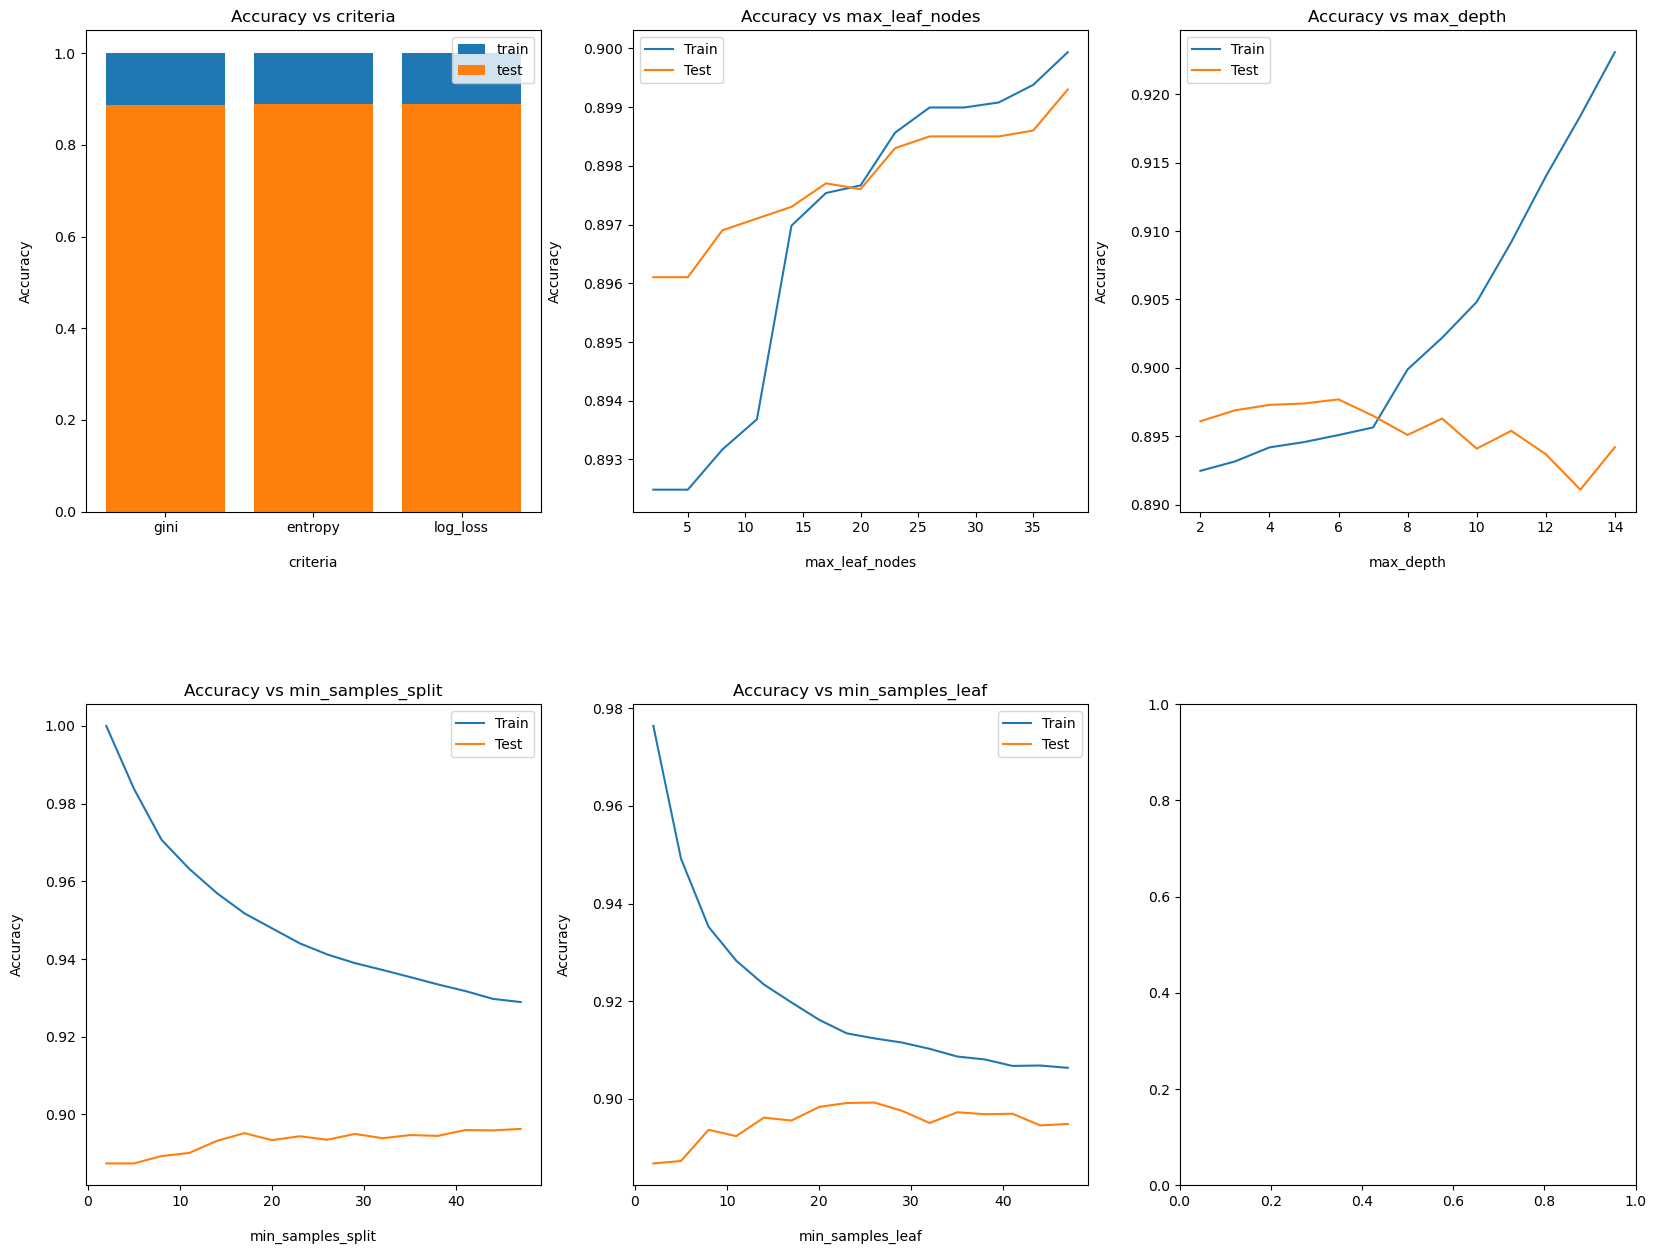

In [322]:
compare_parameters(params, test_acc, train_acc)

Построим дерево с наилучшими параметрами

Model: DecisionTreeClassifier(max_depth=6, max_leaf_nodes=35, min_samples_leaf=44,
                       min_samples_split=47)
Score: 0.895


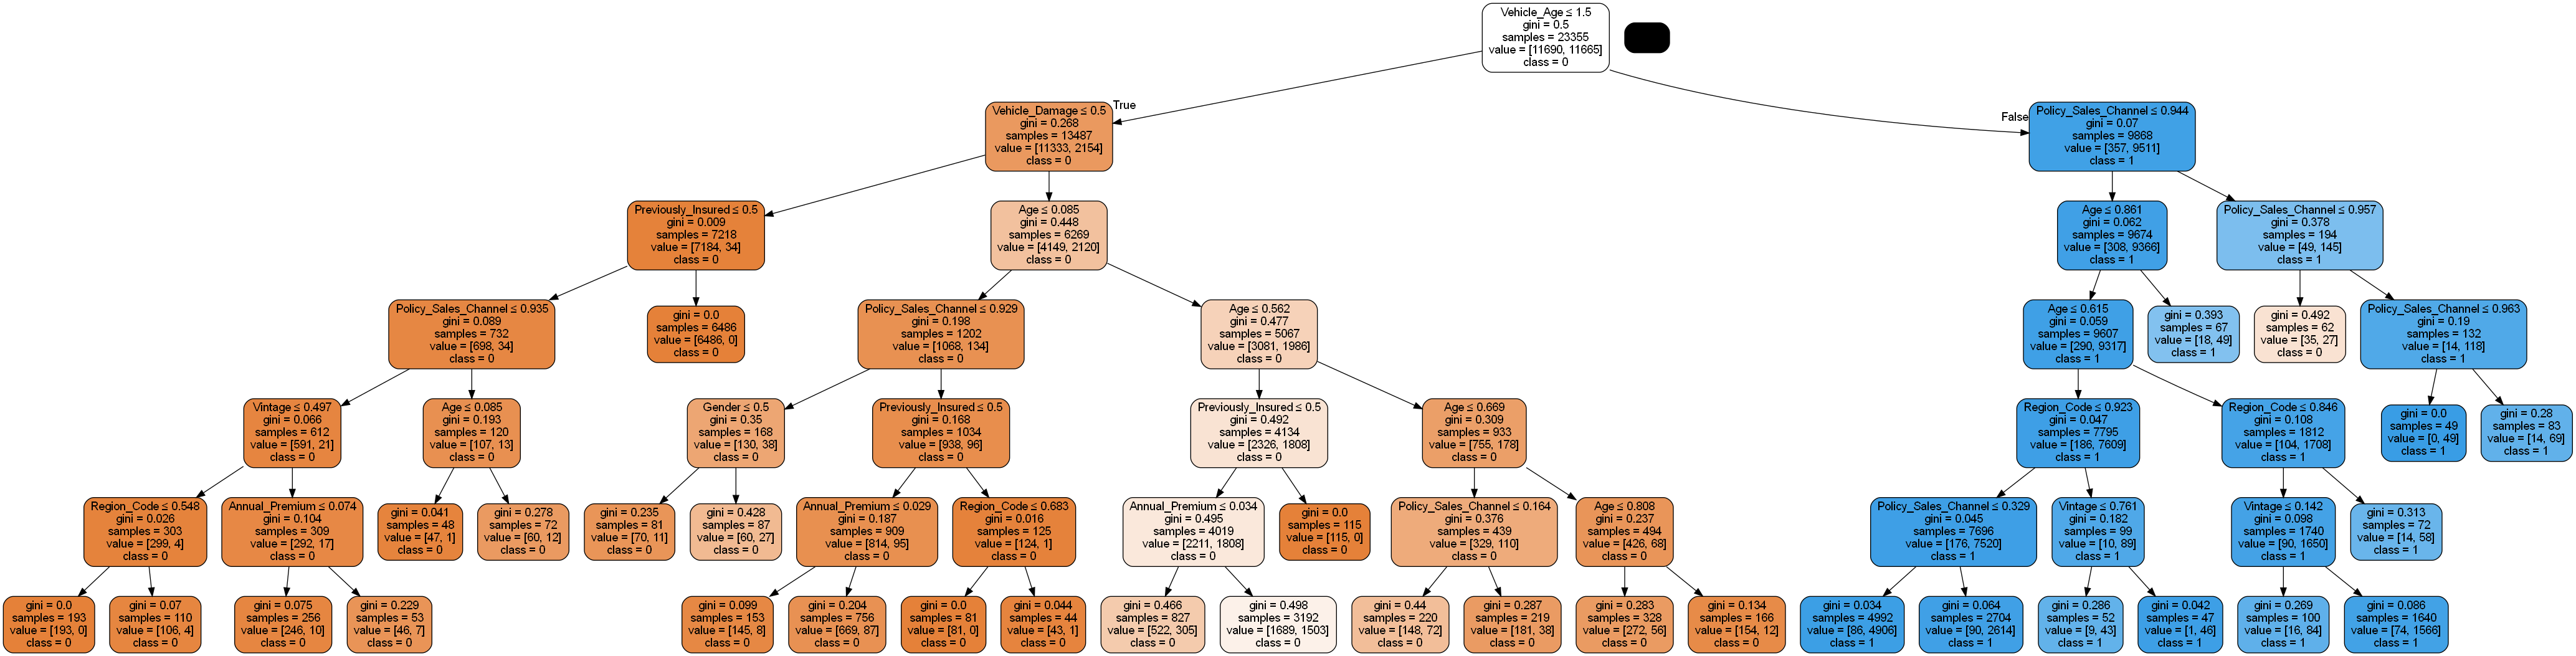

In [323]:
model, class_score = create_best_model(best_parameters_с)
plot_tree_image(model, class_all, "class_tree.png")

### Регрессия
Определим зависимость качества прогнозирования от высоты дерева

In [324]:
train_acc = {}
test_acc = {}
best_parameters_r = dict()
params = {
    "criterion": ["poisson", "friedman_mse", "absolute_error", "squared_error"],
    "max_leaf_nodes": range(2, 40, 3),
    "max_depth": range(2, 15),
    "min_samples_split": range(2, 50, 3),
    "min_samples_leaf": range(2, 50, 3)
}

In [325]:
best_parameters_r["criterion"] = test_parameters({"criterion": params["criterion"]},
                                               x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(criterion='friedman_mse')
Accuracy: 0.802


In [326]:
best_parameters_r["max_leaf_nodes"] = test_parameters({"max_leaf_nodes": params["max_leaf_nodes"]},
                                                    x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(max_leaf_nodes=17)
Accuracy: 0.845


In [327]:
best_parameters_r["max_depth"] = test_parameters({"max_depth": params["max_depth"]},
                                               x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(max_depth=4)
Accuracy: 0.844


In [328]:
best_parameters_r["min_samples_split"] = test_parameters({"min_samples_split": params["min_samples_split"]},
                                                       x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(min_samples_split=26)
Accuracy: 0.852


In [329]:
best_parameters_r["min_samples_leaf"] = test_parameters({"min_samples_leaf": params["min_samples_leaf"]},
                                                      x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(min_samples_leaf=14)
Accuracy: 0.856


Построим графики зависимости score модели от каждого из её параметров

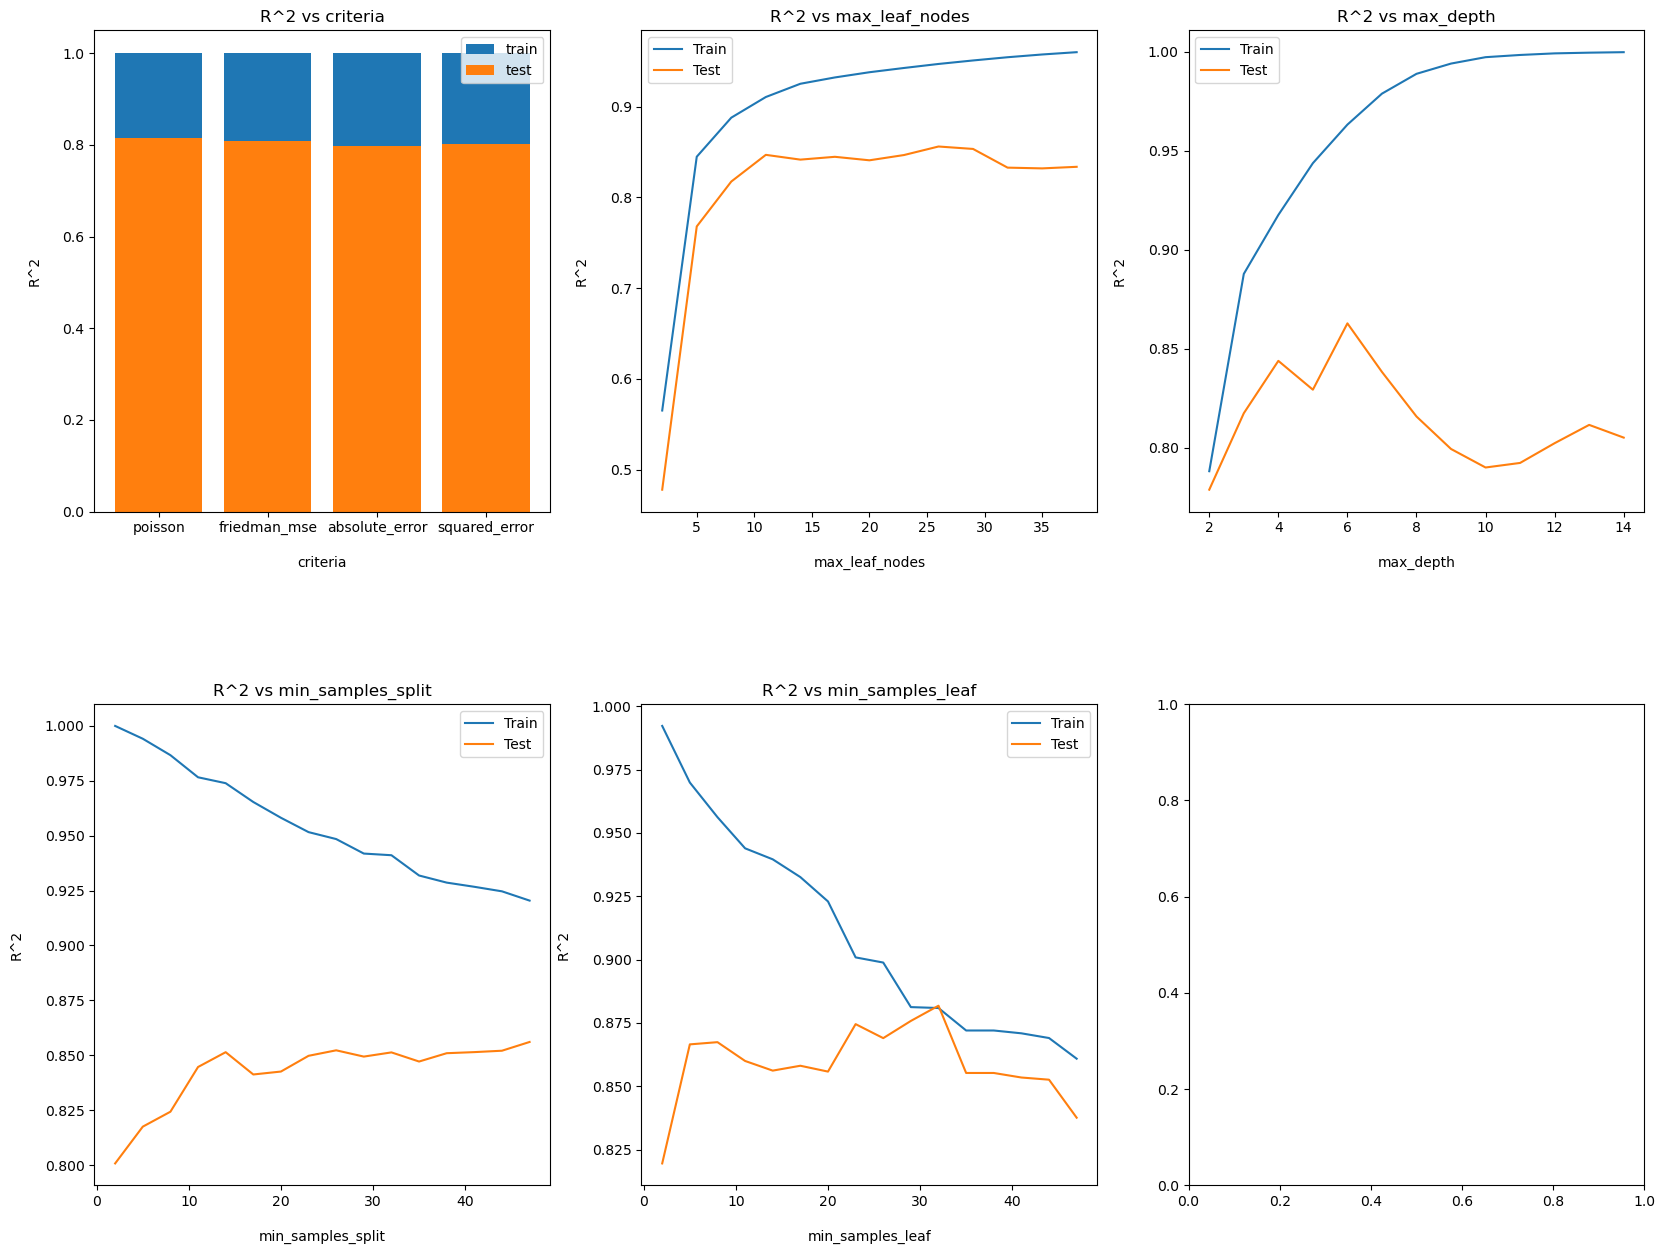

In [330]:
compare_parameters(params, test_acc, train_acc, is_regression=True)

Построим дерево с наилучшими параметрами

Model: DecisionTreeRegressor(criterion='friedman_mse', max_depth=4, max_leaf_nodes=17,
                      min_samples_leaf=14, min_samples_split=26)
Score: 0.849


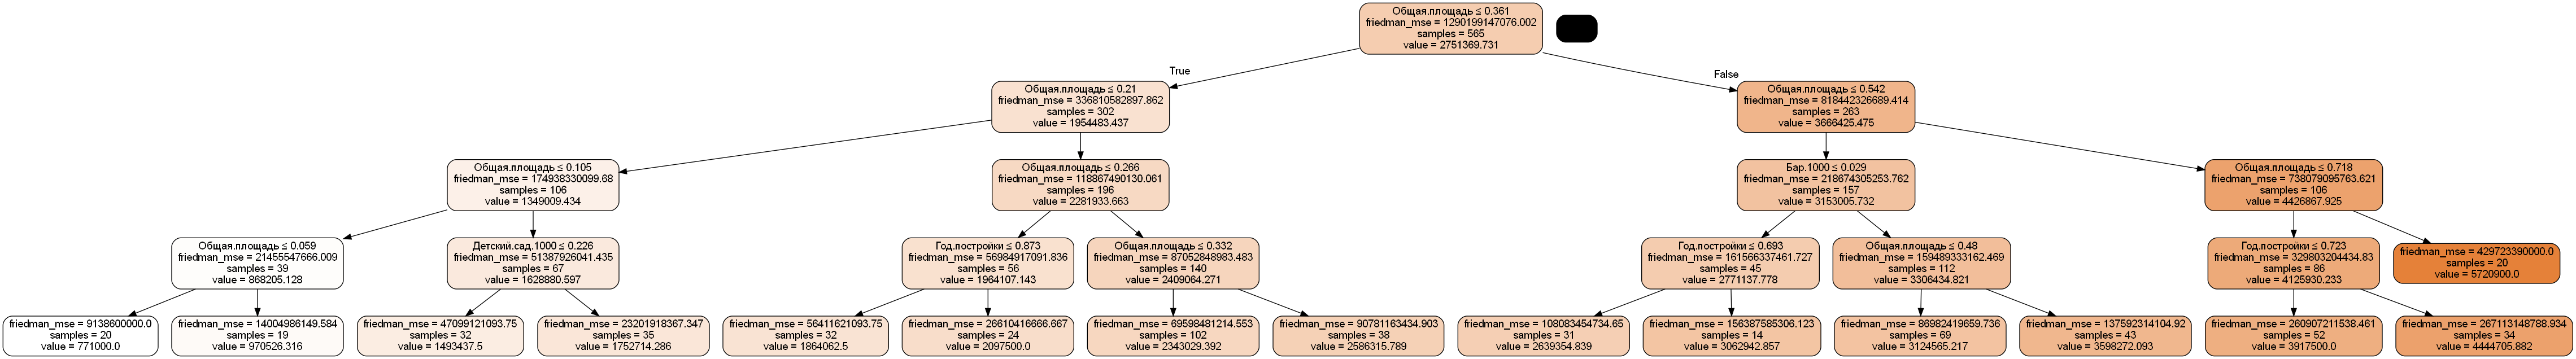

In [331]:
model, regr_score = create_best_model(best_parameters_r, is_regression=True)
plot_tree_image(model, regression_all, "regression_tree.png")

## Обрезка деревьев
### Классификация
Выберем лучшее значение ccp_alphas

In [332]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)
path = dt.cost_complexity_pruning_path(x_train_c, y_train_c)
ccp_alphas = path.ccp_alphas
params = {
    "ccp_alpha": path.ccp_alphas
}
best_cpp = test_parameters(params, x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(ccp_alpha=0.00019043891227131504)
Accuracy: 0.965


Построим обрезанное дерево

Model: DecisionTreeClassifier(ccp_alpha=0.00019043891227131504, max_depth=6,
                       max_leaf_nodes=35, min_samples_leaf=44,
                       min_samples_split=47)
Score: 0.895


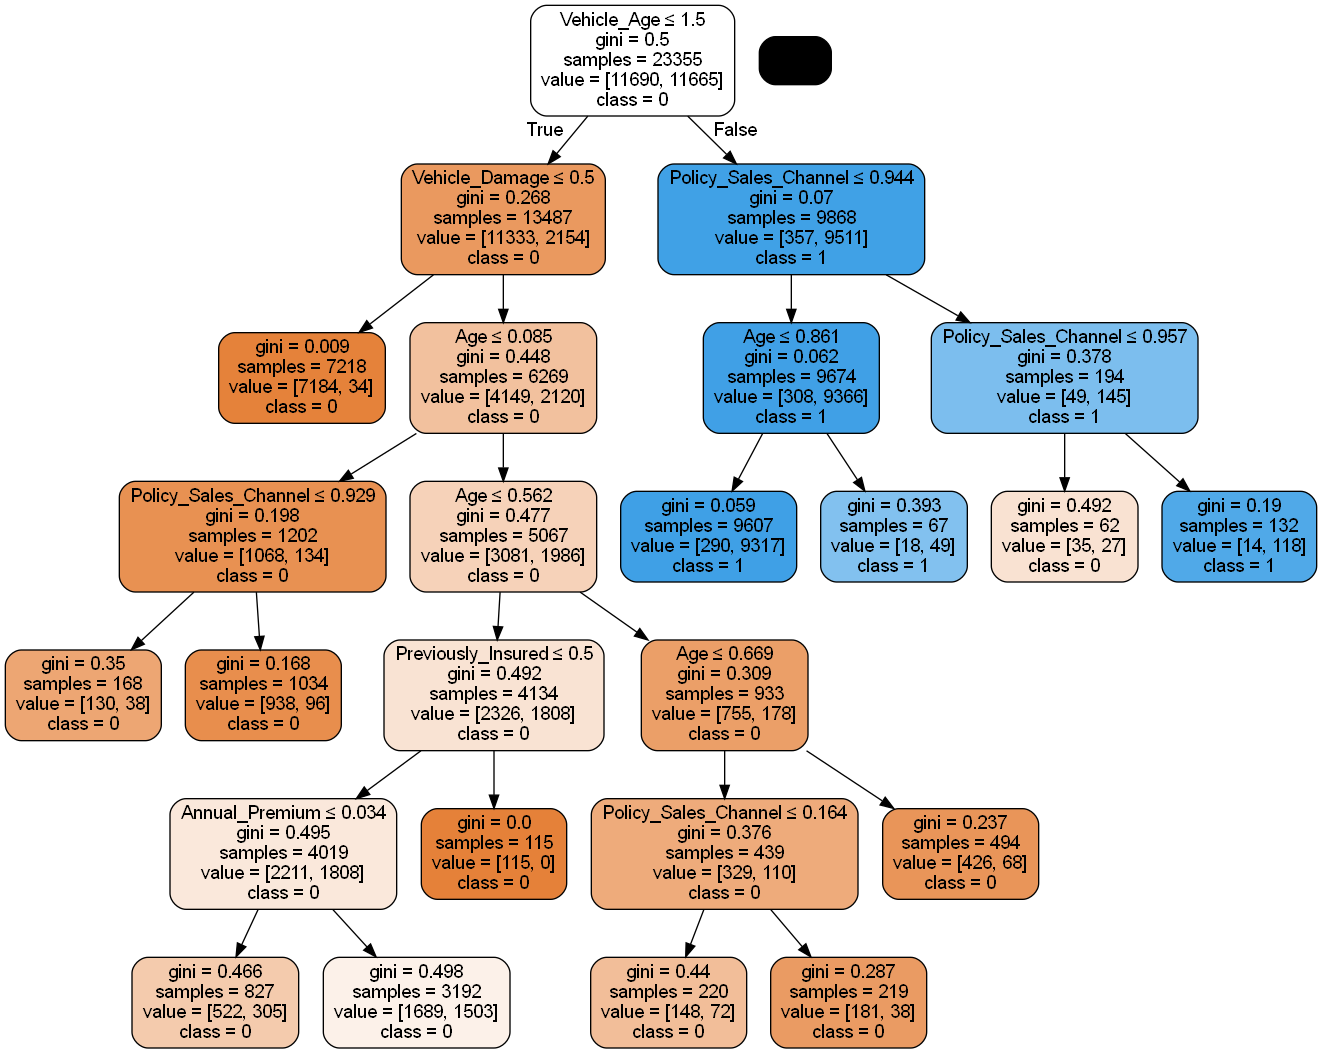

In [333]:
best_parameters_с["ccp_alpha"] = best_cpp
model, score_a_c = create_best_model(best_parameters_с)
plot_tree_image(model, class_all, "new_class.png")

### Регрессия
Выберем лучшее значение ccp_alphas

In [334]:
dt = DecisionTreeRegressor(max_depth=5)
path = dt.cost_complexity_pruning_path(x_train_r, y_train_r)
params = {
    "ccp_alpha": path.ccp_alphas
}
best_cpp = test_parameters(params, x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(ccp_alpha=2900300111.9946404)
Accuracy: 0.838


Построим обрезанное дерево

Model: DecisionTreeRegressor(ccp_alpha=2900300111.9946404, criterion='friedman_mse',
                      max_depth=4, max_leaf_nodes=17, min_samples_leaf=14,
                      min_samples_split=26)
Score: 0.839


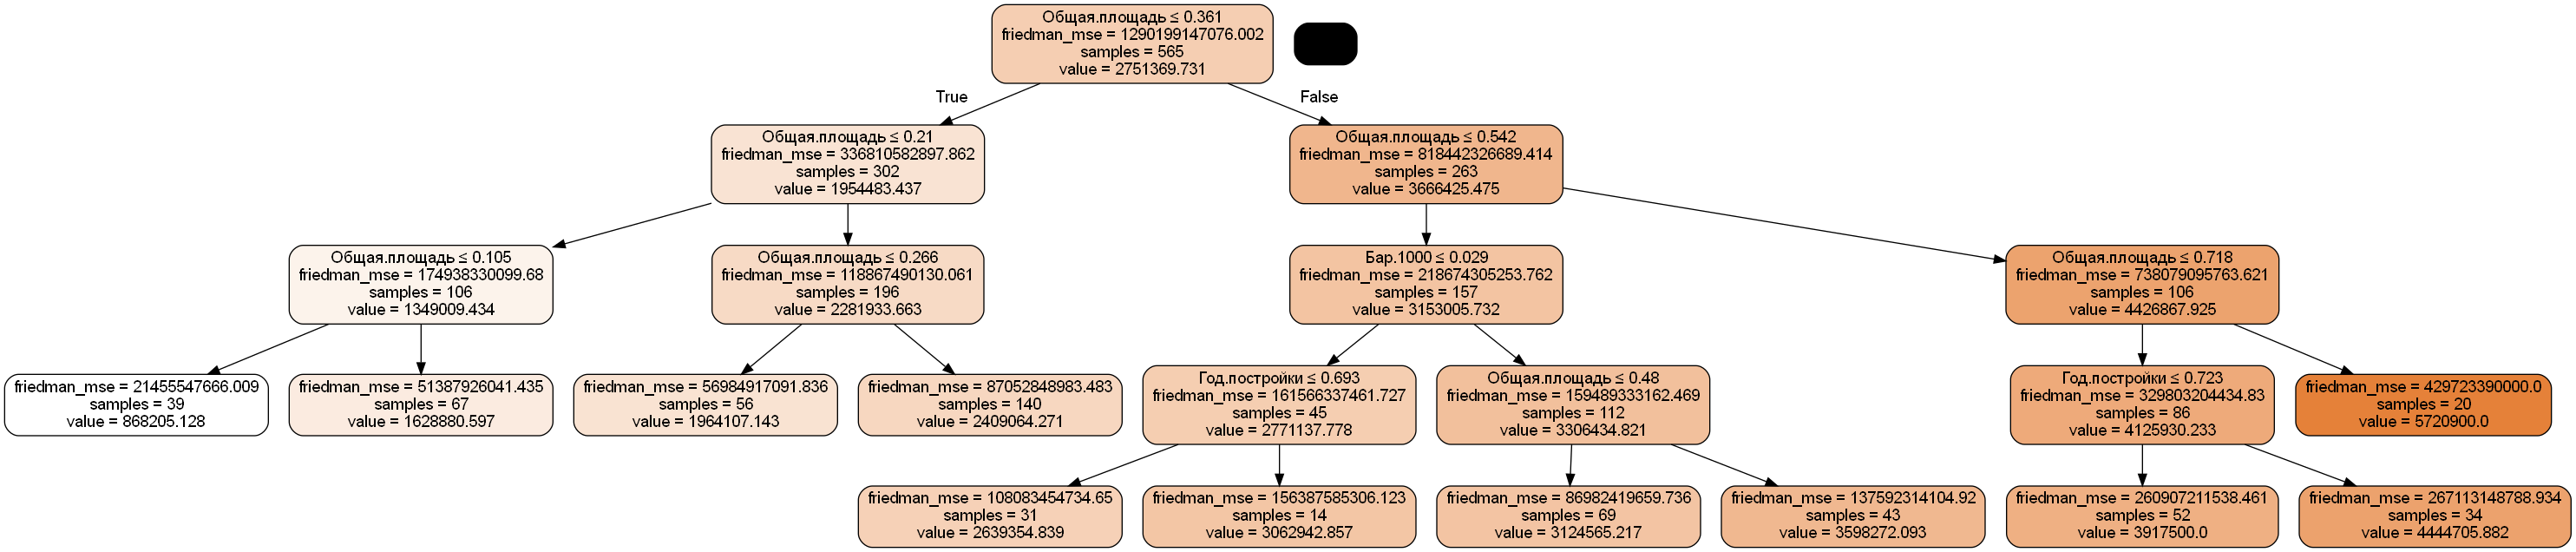

In [335]:
best_parameters_r["ccp_alpha"] = best_cpp
model, _ = create_best_model(best_parameters_r, is_regression=True)
plot_tree_image(model, regression_all, "new_regression.png")

Можно увидеть, что обрезка дерева приводит к увеличению score для тестовой выборки

## Сравнение результатов
Скопируем данные из прошлых практических работ

In [336]:
class_models = pd.DataFrame(
    {
        "Model name": ["LogisticRegression", "KNeighborsClassifier", "GaussianNB", "LinearDiscriminantAnalysis",
                         "QuadraticDiscriminantAnalysis", "SVC"],
        "Score": [0.923, 0.951, 0.938, 0.922, 0.937, 0.929],
    }
)

In [337]:
regression_models = pd.DataFrame(
    {
        "Model name": ["Линейная регрессия", "Лассо регрессия", "Гребневая регрессия", "Elastic-Net", "Метод наименьших углов",
                       "Байесовская регрессия", "Обобщённая линейная регрессия", "Взвешенный МНК", "Полиномиальная регрессия",
                       "Непараметрическая регрессия", "Ядерная регрессия"],
        "R^2": [0.893, 0.892, 0.892, 0.886, 0.893, 0.892, 0.874, 0.876, 0.893, 0.716, 0.897],
    }
)

Добавим результаты, полученные с помощью деревьев решений

In [338]:
class_models.loc[len(class_models.index)] = ["Деревья решений", round(class_score, 3)]
print(class_models)
regression_models.loc[len(regression_models.index)] = ["Деревья решений", round(regr_score, 3)]
print(regression_models)

                      Model name  Score
0             LogisticRegression  0.923
1           KNeighborsClassifier  0.951
2                     GaussianNB  0.938
3     LinearDiscriminantAnalysis  0.922
4  QuadraticDiscriminantAnalysis  0.937
5                            SVC  0.929
6                Деревья решений  0.895
                       Model name    R^2
0              Линейная регрессия  0.893
1                 Лассо регрессия  0.892
2             Гребневая регрессия  0.892
3                     Elastic-Net  0.886
4          Метод наименьших углов  0.893
5           Байесовская регрессия  0.892
6   Обобщённая линейная регрессия  0.874
7                  Взвешенный МНК  0.876
8        Полиномиальная регрессия  0.893
9     Непараметрическая регрессия  0.716
10              Ядерная регрессия  0.897
11                Деревья решений  0.849


Построим столбчатые диаграммы

In [339]:
def plot_bar_graph(ax, names, scoring, title):
    """
    Строит столбчатую диаграмму для score моделей
    :param ax: ось, на которой строим график
    :param names: значения параметров
    :param scoring: оценки при данных значениях параметров
    :param title: заголовок для графика
    :return:
    """
    ax.bar(names, scoring)
    ax.set_title(title)
    ax.tick_params("x", labelrotation=90)
    ax.set_ylim((0.5, 1))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    for rect, score in zip(ax.patches, scoring):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")
    ax.set_xlabel("Model", labelpad=15)
    ax.set_ylabel("Score", labelpad=15)

In [340]:
def compare_models():
    """
    Выводит графики для сравнения моделей
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    fig.subplots_adjust(hspace=0.4)
    plot_bar_graph(axs[0], regression_models["Model name"], regression_models["R^2"], "Regression")
    plot_bar_graph(axs[1], class_models["Model name"], class_models["Score"], "Classification")

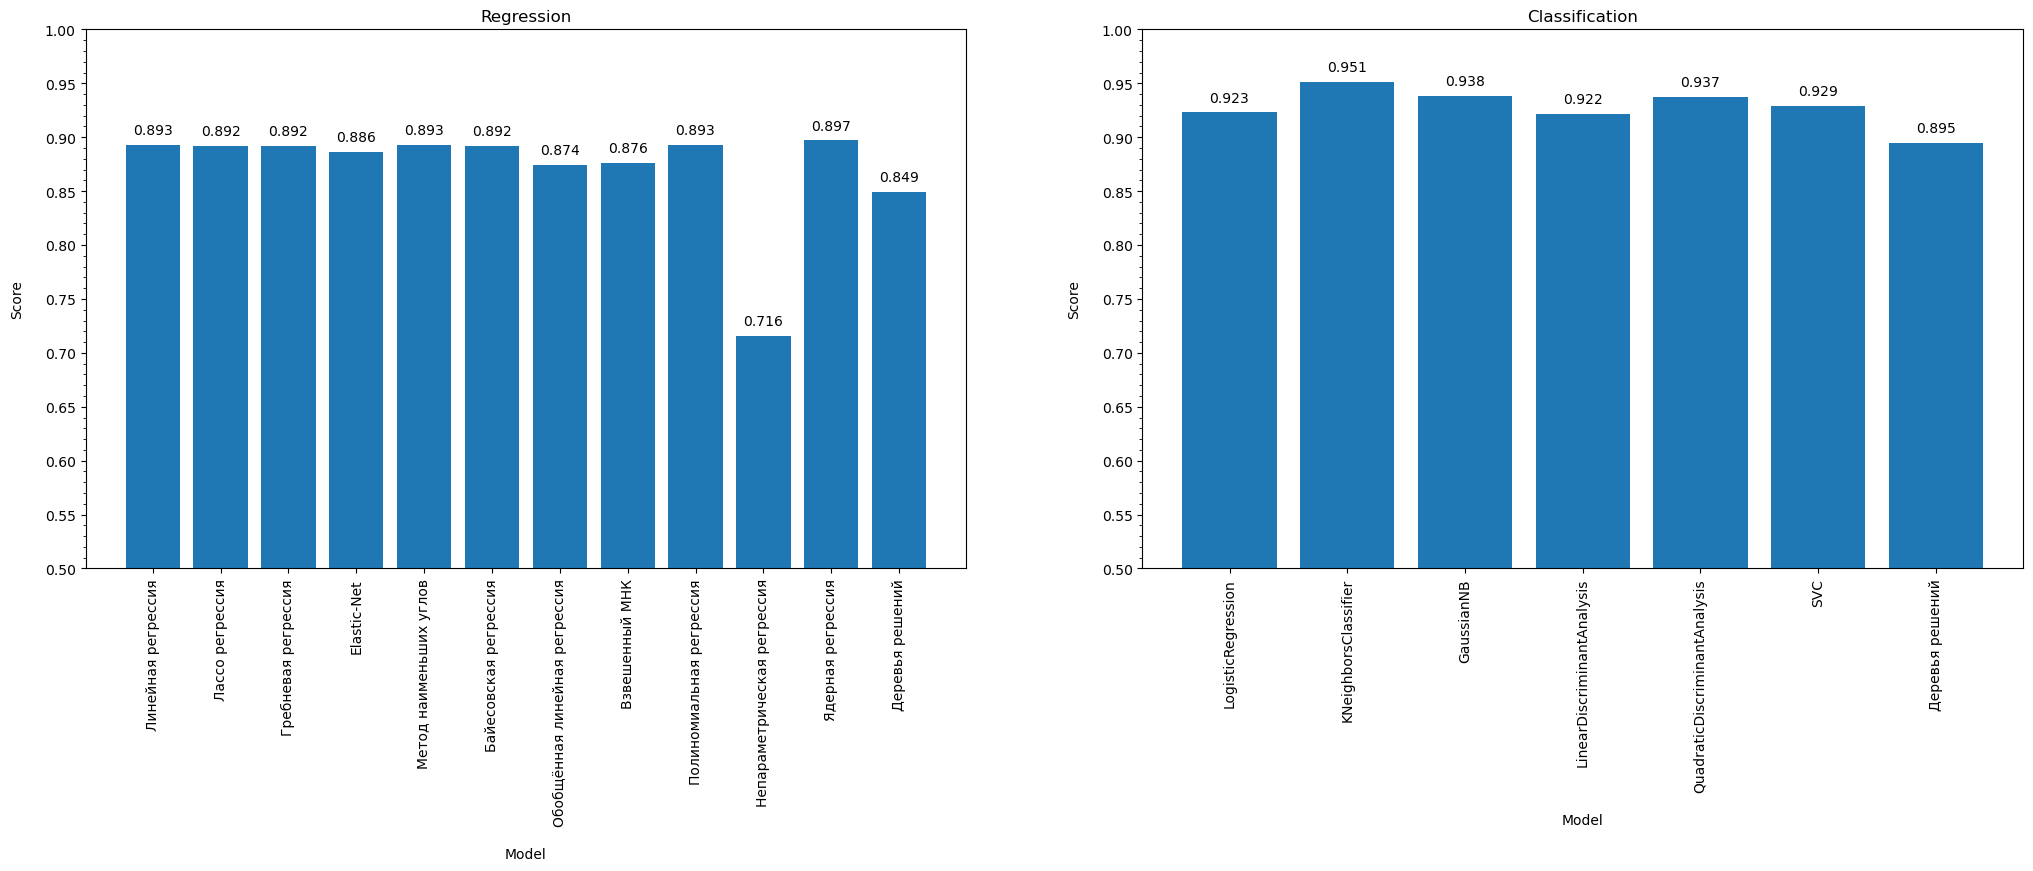

In [341]:
compare_models()